In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 28 June 2023
# Description:
#     this script obtain and save the 1500m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates

# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')


In [2]:
client = Client(n_workers=56,threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/32899/status,
Dashboard: /proxy/32899/status,Workers: 56
Total threads: 56,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41687,Workers: 56
Dashboard: /proxy/32899/status,Total threads: 56
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40649,Total threads: 1
Dashboard: /proxy/45373/status,Memory: 0 B
Nanny: tcp://127.0.0.1:36893,


In [3]:
%%time

# load ice draft to create masks
di = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

# ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
# ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
# based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

h = dg.h.load()

h = h*mask_zice

# Fill in land with zeros:
h = h.fillna(0)

contour_depth = 1500.

## Choose whether you want your contour on the u or t grid.
grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho
 



CPU times: user 4.86 s, sys: 2.07 s, total: 6.93 s
Wall time: 7.69 s


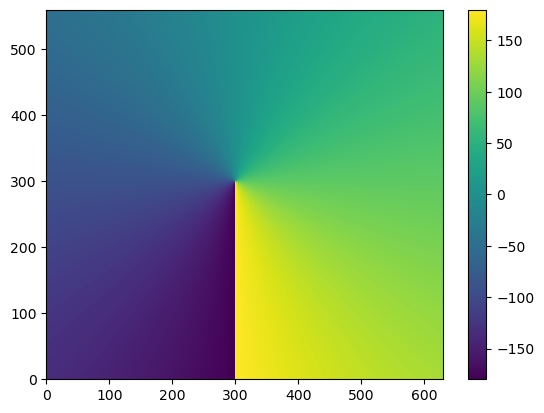

In [4]:
plt.pcolormesh(lon_rho)
plt.colorbar()

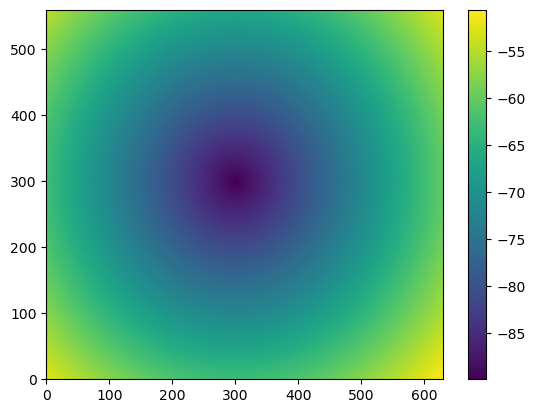

In [5]:
plt.pcolormesh(lat_rho)
plt.colorbar()

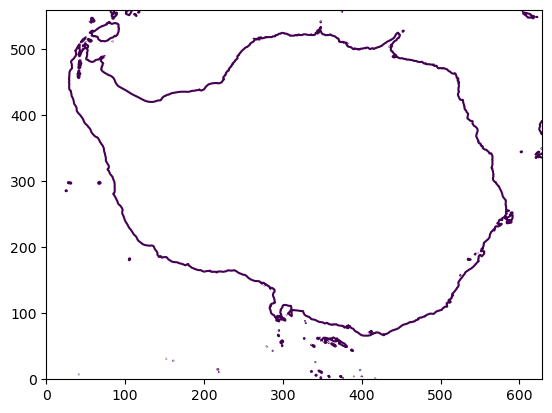

In [6]:
sc = plt.contour(h, levels=[1500])
# plt.xlim(360,410)
# plt.ylim(65,85)

In [7]:
# # first save all contours in individual plot to scam for the number of the desired contour:

# for cc in np.arange(0,213):
#     fig = plt.figure(figsize = (8, 6))
#     count = cc
#     x_contour = []
#     y_contour = []

#     # Create the contour:
#     sc = plt.contour(h, levels=[contour_depth])
#     for collection in sc.collections:
#         for path in collection.get_paths():
#             # print(collection.get_paths())
        
#             count += 1
#             if count ==  212:
#                 # Write down the lat/lon indices
#                 for ii in range(np.size(path.vertices[:,0])):
#                     x_contour.append(int(np.round(path.vertices[ii][0])))
#                     y_contour.append(int(np.round(path.vertices[ii][1])))

#     plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

#     name_fig="/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/waom10extend_1500m_contour_cc=" + str(cc) + ".png"
#     plt.savefig(name_fig, dpi=300)
#     plt.close()

# THIS DOESN'T WORK ANYMORE (FEB24); IT KEEP GATHERING ALL CONTOURS. HAD TO SEPARATE IT MANUALLY (SEE BELOW).

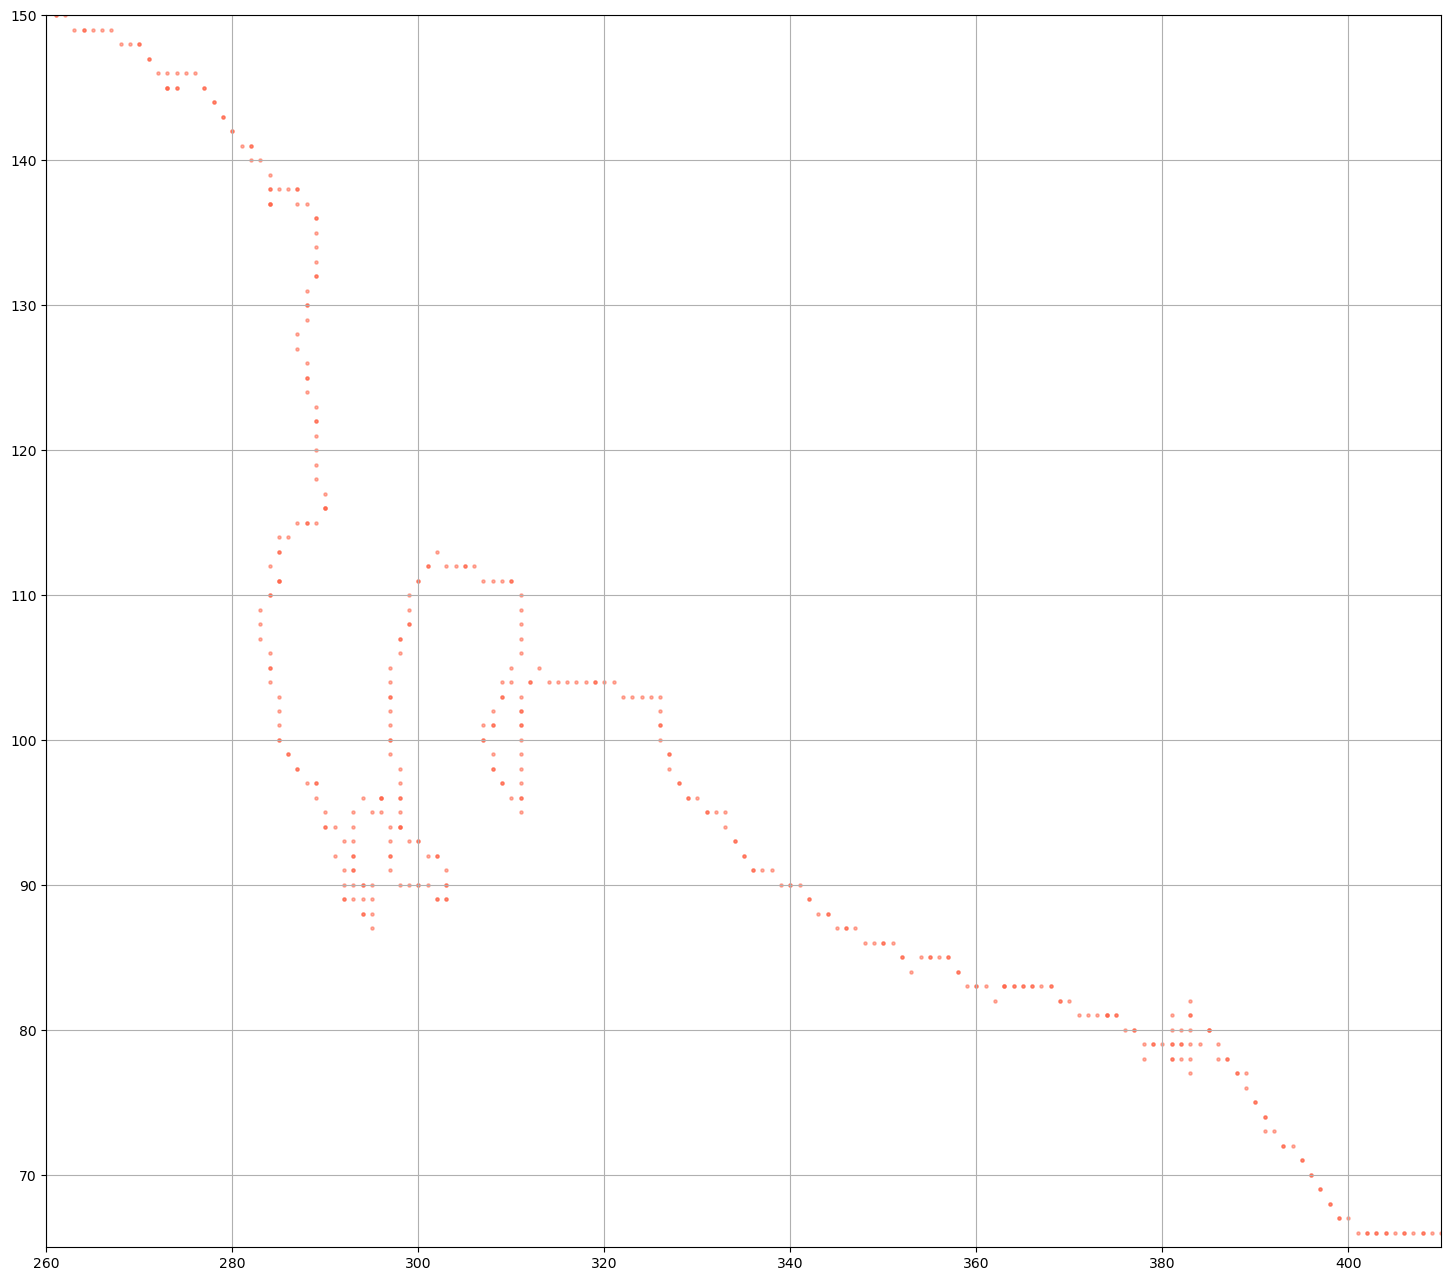

In [8]:
fig = plt.figure(figsize = (18, 16))
count = 0
x_contour = []
y_contour = []

# Create the contour:
# sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        
        count += 1
        
        if count == 1:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

xi=494
xf=3279
plt.scatter(x_contour[xi:xf], y_contour[xi:xf], s=5, alpha=0.5, color='tomato');
# plt.xlim(300,450)
# plt.ylim(50,100)
plt.xlim(260,410)
plt.ylim(65,150)
plt.grid('on')

In [9]:
xf-xi
# cut only circum-antarctic contour:
x_contour = x_contour[xi:xf]
y_contour = y_contour[xi:xf]


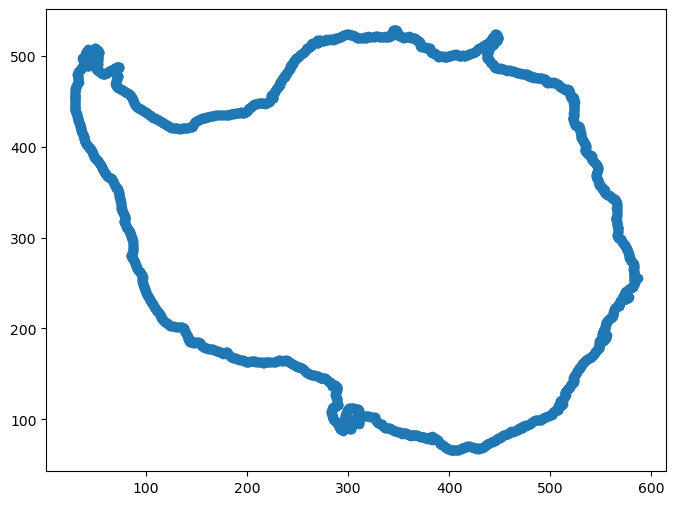

In [10]:

fig = plt.figure(figsize = (8, 6))

# plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='k');#tomato');
plt.plot(x_contour, y_contour,'o')
# plt.ylim(350,520)
# plt.xlim(0,100)
# plt.xlim(300,450)
# plt.ylim(50,100)
# plt.xlim(260,410)
# plt.ylim(65,150)

In [11]:
len(x_contour)

2785

In [12]:
# save x_contour, y_contour

xcon_np = np.asarray(x_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv", xcon_np, delimiter=",")

ycon_np = np.asarray(y_contour)
np.savetxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv", ycon_np, delimiter=",")


In [13]:
# to re-load
xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv")
x_contour = xcon_np.tolist()
ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv")
y_contour = ycon_np.tolist()

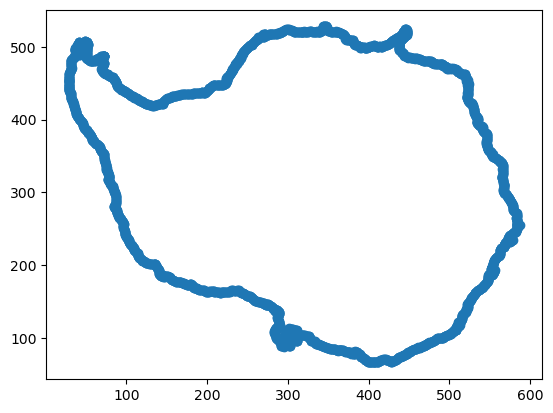

In [14]:
plt.plot(x_contour, y_contour,'o')

In [15]:
# for ii in range(0,len(x_contour)):
#         # ?contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1
#         print(int(y_contour[ii]), int(x_contour[ii]))

#### calculate vol_transp here for testing - are the cross-contour transports correct?


In [16]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[int(y_contour[ii]), int(x_contour[ii])]

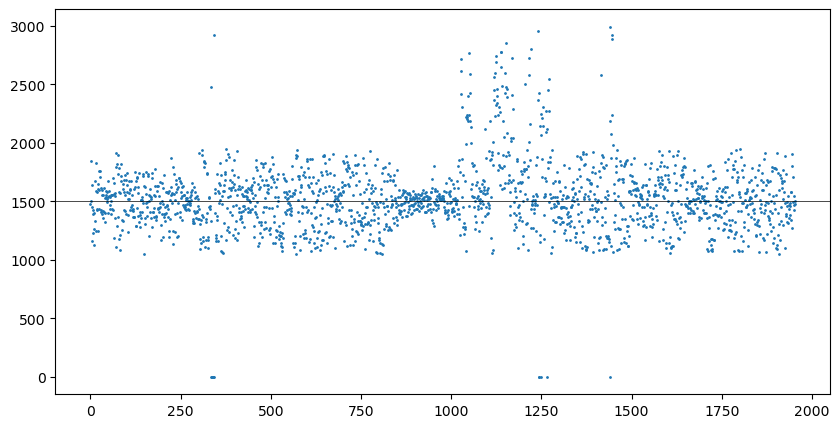

In [17]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [18]:
# Get lat/lon along the contour

# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[int(y_contour[ii-1]),int(x_contour[ii-1])]
    lat_along_contour[ii] = y_var[int(y_contour[ii-1]),int(x_contour[ii-1])]

# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)

lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

contour_mask = h*0

In [19]:
for ii in range(num_points-1):
    contour_mask[int(y_contour[ii]), int(x_contour[ii])] = contour_mask_numbered[ii]+1
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

#Create mask
#Now we create a mask below contour sothat the direction of the contour can be determined

#Remark on computational inefficiency:
#Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.
#See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

print(contour_masked_above.shape, contour_mask_numbered.shape)
print(contour_masked_above[-20:-1, 0])

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

(560, 630) (560, 630)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
#from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if north of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

In [21]:
# save contour_masked_above
files_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
contour_masked_above.dump(files_path + 'WAOM10_contour_masked_above_1500m_v3')

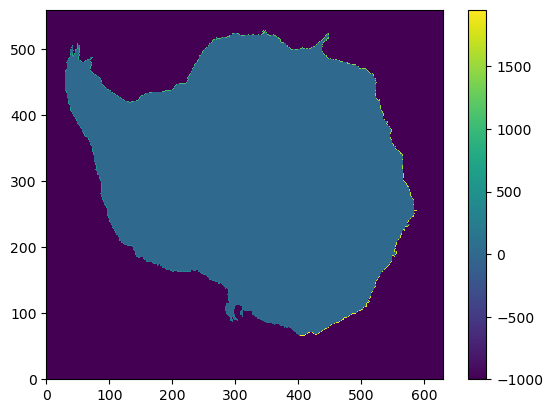

In [22]:
plt.pcolormesh(contour_masked_above)#, vmin=650, vmax=850)
plt.colorbar()
# plt.xlim(250,400)
# plt.ylim(0,150)

In [23]:
# Direction of cross-contour transport

mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos: add 2 extra columns with the value of the last/first columns of the original 
# Fabio Mar24: I don't think this is needed for ROMS; duplicating i/x coordinating (prob. for longitude gap propose?)
shape = contour_masked_above.shape
# contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
# contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
# contour_masked_above_halo[:, 1:-1] = contour_masked_above
# contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]


In [24]:
contour_masked_above.shape

(560, 630)

In [25]:
new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    
    # 1A) if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
        
    # 1B) if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
        
    # 1C) if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        mask_y_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2
        
    # 2A) if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above[index_j, index_i+1]==0) and (contour_masked_above[index_j, index_i-1]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
        
    # 2B) if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
        
    # 2C) if point to left and right BOTH toward Antarctica
    elif (contour_masked_above[index_j, index_i-1]==0) and (contour_masked_above[index_j, index_i+1]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        mask_x_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2

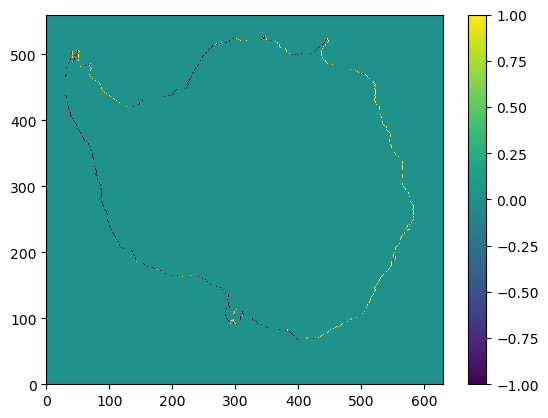

In [26]:
# checking masks x/y transport:


plt.pcolormesh(mask_x_transport)#, vmin=0, vmax=100)
plt.colorbar()
# plt.xlim(260,410)
# plt.ylim(65,150)
# plt.xlim(350,410)
# plt.ylim(60,90)
# plt.xlim(20,40)
# plt.ylim(420,440)

In [27]:
print(mask_y_transport.shape)

(560, 630)


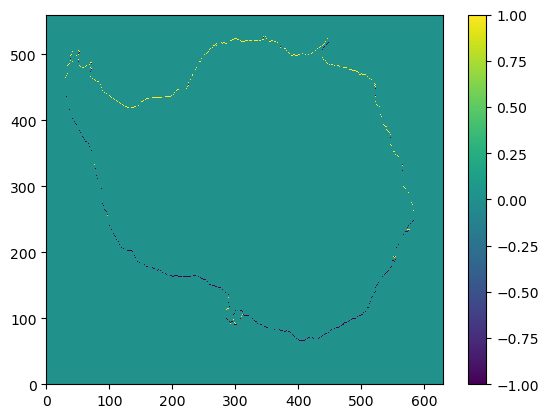

In [28]:
# checking masks x/y transport:

plt.pcolormesh(mask_y_transport)#, vmin=0, vmax=100)
plt.colorbar()
# plt.xlim(260,410)
# plt.ylim(65,150)
# plt.xlim(350,410)
# plt.ylim(60,90)
# plt.xlim(20,40)
# plt.ylim(420,440)

In [29]:
print(mask_y_transport.shape)
print(lon_rho.shape)
print(lat_rho.shape)

(560, 630)
(560, 630)
(560, 630)


In [30]:
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

# save mask_x/y_transport for inspection;
coordinates=dict(lon=(['lon_rho','lat_rho'],dg.lon_rho.data), lat=(['lon_rho','lat_rho'], dg.lat_rho.data))
    
mask_x_transport_xr = xr.DataArray(mask_x_transport, coords = coordinates, dims = ['lon_rho','lat_rho'])
mask_y_transport_xr = xr.DataArray(mask_y_transport, coords = coordinates, dims = ['lon_rho','lat_rho'])

# rename vars:
mask_x_transport_xr.name = 'mask_x_transport'
mask_y_transport_xr.name = 'mask_y_transport'

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross-1500m_transp/'

mask_x_transport_xr.to_netcdf(files_path + 'mask_x_transport.nc', mode='w', format="NETCDF4")
mask_y_transport_xr.to_netcdf(files_path + 'mask_y_transport.nc', mode='w', format="NETCDF4")


(420.0, 440.0)

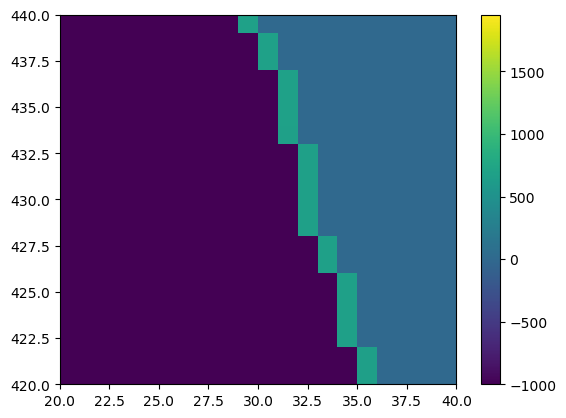

In [31]:
plt.pcolormesh(contour_masked_above)#, vmin=0, vmax=100)
plt.colorbar()
# plt.xlim(260,410)
# plt.ylim(65,150)
# plt.xlim(350,410)
# plt.ylim(60,90)
plt.xlim(20,40)
plt.ylim(420,440)

In [32]:
# # Original (before Mar24); keep for comparison

# new_number_count = 1
# for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
#     #if mask_loc%100 == 0:
#     #    print('mask for x/y transport at point '+str(mask_loc))
#     index_i = np.where(contour_mask_numbered==mask_loc)[1]
#     index_j = np.where(contour_mask_numbered==mask_loc)[0]
    
#     # 1A) if point above is towards Antarctica and point below is away from Antarctica:
#     # take transport grid point to north of t grid:
#     if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
#         mask_y_transport[index_j, index_i] = -1
#         # important to do
#         mask_y_transport_numbered[index_j, index_i] = new_number_count
#         new_number_count += 1
        
#     # 1B) if point below is towards Antarctica and point above is away from Antarctica:
#     # take transport grid point to south of t grid:
#     elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
#         mask_y_transport[index_j-1, index_i] = 1
#         mask_y_transport_numbered[index_j-1, index_i] = new_number_count
#         new_number_count += 1
        
#     # 1C) if point below and point above are BOTH towards Antarctica:
#     # take transport grid point to south of t grid:
#     elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
#         mask_y_transport[index_j-1, index_i] = 1
#         mask_y_transport[index_j, index_i] = -1
#         mask_y_transport_numbered[index_j-1, index_i] = new_number_count
#         mask_y_transport_numbered[index_j, index_i] = new_number_count+1
#         new_number_count += 2
        
#     # 2A) if point to right is towards Antarctica and point to left is away from Antarctica:
#     # zonal indices increased by 1 due to halos
#     # take transport grid point on right of t grid:
#     if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
#         mask_x_transport[index_j, index_i] = -1
#         mask_x_transport_numbered[index_j, index_i] = new_number_count
#         new_number_count += 1
        
#     # 2B) if point to left is towards Antarctica and point to right is away from Antarctica:
#     # take transport grid point on left of t grid:
#     elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
#         mask_x_transport[index_j, index_i-1] = 1
#         mask_x_transport_numbered[index_j, index_i-1] = new_number_count
#         new_number_count += 1
        
#     # 2C) if point to left and right BOTH toward Antarctica
#     elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]==0):
#         mask_x_transport[index_j, index_i-1] = 1
#         mask_x_transport[index_j, index_i] = -1
#         mask_x_transport_numbered[index_j, index_i-1] = new_number_count
#         mask_x_transport_numbered[index_j, index_i] = new_number_count+1
#         new_number_count += 2

In [33]:
# We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport.

print(pm.shape, pn.shape)

# Now we need to interpolate the mask_x/y_transport to the corresponding lon/lat_u/v grids
# so we can multiply by the U/V transport

## UPDATE Mar24: I don't think need to interpolate; the choice of getting the mask_x/y_transport accordingly with the c-arakawa grids, 
# that I think this in not necessary.

# re-grid from rho to u/v-grids
# rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
# u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
# v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)

# wf = lambda r: 1/r

# mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport,u_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport,v_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered,u_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)
# mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered,v_def,\
#                                             radius_of_influence=100000,neighbours=1,weight_funcs=wf)

# # Convert contour masks to data arrays, so we can multiply them later.
# # We need to ensure the lat lon coordinates correspond to the actual data location:
# #       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
# #       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
# #       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
# #       to make concatenation of transports in both direction and sorting possible.
# coordinates=dict(one=lon_rho, two=lat_rho)
# coordinatesU=dict(one=lon_u, two=lat_u)
# coordinatesV=dict(one=lon_v, two=lat_v)


# mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
# mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
# mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
# mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])

# # rename dimensions as simply eta/xi
# mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
# mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})
# mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
# mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})

# # Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
# #   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
# #   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
# #   but we dont double up with numerous counts for one lat/lon point.

# # stack contour data into 1d:
# mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
# mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

# mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
# mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

# contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
# contour_ordering = contour_ordering.sortby(contour_ordering)
# contour_index_array = np.arange(1, len(contour_ordering)+1)

(560, 630) (560, 630)


In [34]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)

mask_x_transport = xr.DataArray(mask_x_transport, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = coordinates, dims = ['eta_rho', 'xi_rho'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = coordinates, dims = ['eta_rho', 'xi_rho'])

# rename dimensions as simply eta/xi
mask_x_transport = mask_x_transport.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_y_transport = mask_y_transport.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_x_transport_numbered = mask_x_transport_numbered.rename({'eta_rho': 'eta','xi_rho': 'xi'})
mask_y_transport_numbered = mask_y_transport_numbered.rename({'eta_rho': 'eta','xi_rho': 'xi'})

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

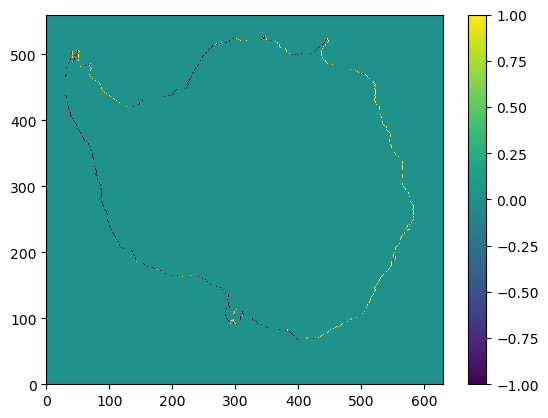

In [35]:
plt.pcolormesh(mask_x_transport)
plt.colorbar()

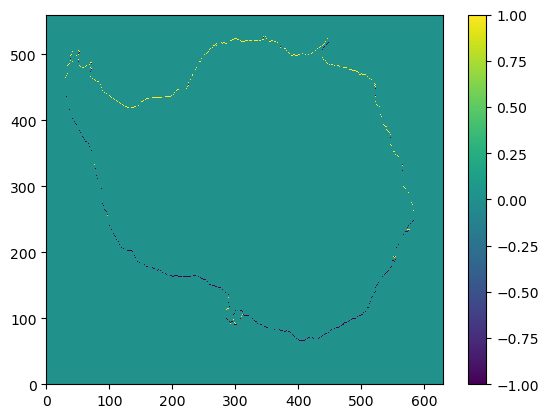

In [36]:
plt.pcolormesh(mask_y_transport)
plt.colorbar()

In [37]:
# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.two
lon_along_contour = contour_ordering.one

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [38]:
# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=True, drop_variables=vars2drop, decode_times=False)

#- preserving daily avgs
temp = ds.variables["temp"]
salt = ds.variables["salt"]
shflux = ds.variables["shflux"]
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"]
Huon = ds.variables["Huon"]
ssh = ds.variables["zeta"]

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

ds.close()

Vtransform=2


In [39]:
%%time

## calculate heat transport and subtract Freezing point heat transport:

# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1
# use same values as in access-om2
rho0=1035
Cp=3992.1
# Tf = -1.95 # degC
Tf =  -3.534879684448242 # coldest temp along 1500m among all three WAOM expts (10km, 4km, 4km-notide)

# 1) multiply rho0*Cp:
HTv = HvomT*rho0*Cp
HTu = HuonT*rho0*Cp

# 2) calculate mean freezing point heat transport: (DONT DO ANNUAL MEAN HERE!!!!)
# VTv_avg = Hvom.mean('ocean_time')
# VTu_avg = Huon.mean('ocean_time')
# HTf_v_avg = VTv_avg*Tf*rho0*Cp
# HTf_u_avg = VTu_avg*Tf*rho0*Cp
HTf_v = Hvom*Tf*rho0*Cp
HTf_u = Huon*Tf*rho0*Cp

# 3) subtract Tf HT from abs HT:
HTv = HTv - HTf_v
HTu = HTu - HTf_u

# 4) rename dimensions before multiplying for mask_x/y_transport:
# convert to DataArray first:
HTv = xr.DataArray(HTv)
HTu = xr.DataArray(HTu)
HTv = HTv.rename({'eta_v': 'eta','xi_v': 'xi'})
HTu = HTu.rename({'eta_u': 'eta','xi_u': 'xi'})

# 4) multiply mask_x/y_transport:
# for tt in range(0,365):
#     for kk in range(0,31):
        # HTv[tt,kk,:,:] = HTv[tt,kk,:,:]*mask_y_transport[:-1,:]
        # HTu[tt,kk,:,:] = HTu[tt,kk,:,:]*mask_x_transport[:,:-1]
# HTvm = HTv*mask_y_transport[:-1,:]
# HTum = HTu*mask_x_transport[:,:-1]

print(HTv.shape, HTu.shape)


(365, 31, 559, 630) (365, 31, 560, 629)
CPU times: user 12.7 ms, sys: 611 µs, total: 13.4 ms
Wall time: 12.8 ms


In [40]:
%%time 
HTv.load()
HTu.load()


CPU times: user 1min 8s, sys: 4min 25s, total: 5min 34s
Wall time: 8min 11s


<xarray.DataArray (ocean_time: 365, s_rho: 31, eta: 560, xi: 629)> Size: 16GB
array([[[[-9.50852506e+09,  1.23823130e+09,  2.07734620e+10, ...,
           1.09490207e+10,  2.12524974e+10,  1.17015296e+10],
         [-2.01307587e+10, -1.64030497e+11, -6.60735713e+10, ...,
           3.89819392e+09,  1.39922637e+10,  6.53075968e+09],
         [-6.85767270e+09, -1.05040044e+11, -1.11050080e+11, ...,
          -5.78423245e+09, -8.17065830e+09,  6.62448947e+09],
         ...,
         [-3.16365742e+10, -1.53445827e+11, -3.96321869e+09, ...,
          -1.98690161e+10, -1.26742866e+10,  1.79094016e+10],
         [-2.00079135e+10, -1.22281460e+11, -5.58420787e+10, ...,
           9.95718513e+10, -2.65489695e+10,  1.95984220e+10],
         [-8.00425370e+09,  2.42322739e+09, -2.02517381e+10, ...,
          -3.61732710e+10, -2.02527048e+10,  1.32973363e+09]],

        [[-2.31668285e+10, -7.74642893e+09,  3.95191869e+10, ...,
           2.23812465e+10,  3.81003735e+10,  2.13628498e+10],
         [-3.95900273e+10, -3.93267347e+11, -1.26340039e+11, ...,
           1.01642035e+10,  2.69754798e+10,  1.24987177e+10],
         [-1.27159357e+10, -1.71075797e+11, -1.47236667e+11, ...,
          -1.04026030e+10, -1.21935319e+10,  9.76201421e+09],
...
           1.29426817e+11,  2.87407702e+11,  1.43180726e+11],
         [ 1.90101504e+11,  1.44238379e+11,  1.63114107e+11, ...,
           4.85565366e+11,  6.58627035e+11,  1.59930892e+11],
         [ 1.91745556e+11,  1.83489430e+11,  1.58738973e+11, ...,
           3.25490442e+11,  3.46683867e+11,  1.61176814e+11]],

        [[-3.69093640e+11, -3.86759459e+11, -4.02946490e+11, ...,
          -2.86496915e+11, -2.37580026e+11, -8.32607273e+10],
         [-3.50643028e+11, -4.35208520e+11, -5.47039937e+11, ...,
          -3.24947509e+11, -3.07726189e+11, -9.00901765e+10],
         [-3.36784916e+11, -2.07393866e+11, -3.00504318e+11, ...,
          -9.75616901e+10, -1.69263366e+11, -7.72742758e+10],
         ...,
         [ 1.31440034e+11,  8.14619361e+10,  3.23142205e+10, ...,
           3.79694940e+11,  3.57458641e+11,  1.03356219e+11],
         [ 1.73537165e+11,  2.22321869e+11,  2.21899882e+11, ...,
           6.32909726e+11,  7.49504627e+11,  1.14232852e+11],
         [ 1.80036829e+11,  1.76287285e+11,  1.67068598e+11, ...,
           3.82802100e+11,  2.62490997e+11,  1.12445202e+11]]]],
      dtype=float32)
Dimensions without coordinates: ocean_time, s_rho, eta, xi

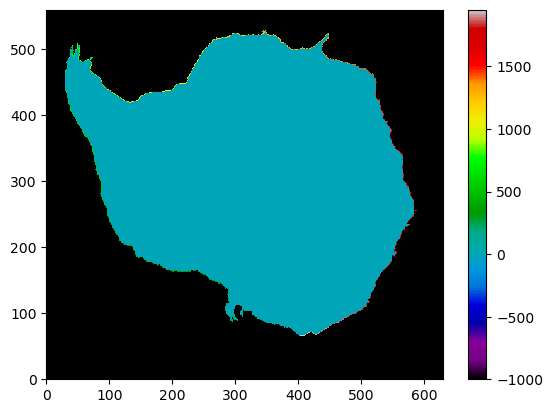

In [42]:
plt.pcolormesh(contour_masked_above, cmap='nipy_spectral')#, vmin=1000, vmax=2700)
plt.colorbar()
# plt.xlim(250,400)
# plt.ylim(0,150)


# create mask for cont. shelf budget:
mask_shelfc = ma.masked_where(contour_masked_above == -1000, np.ones(h.shape))

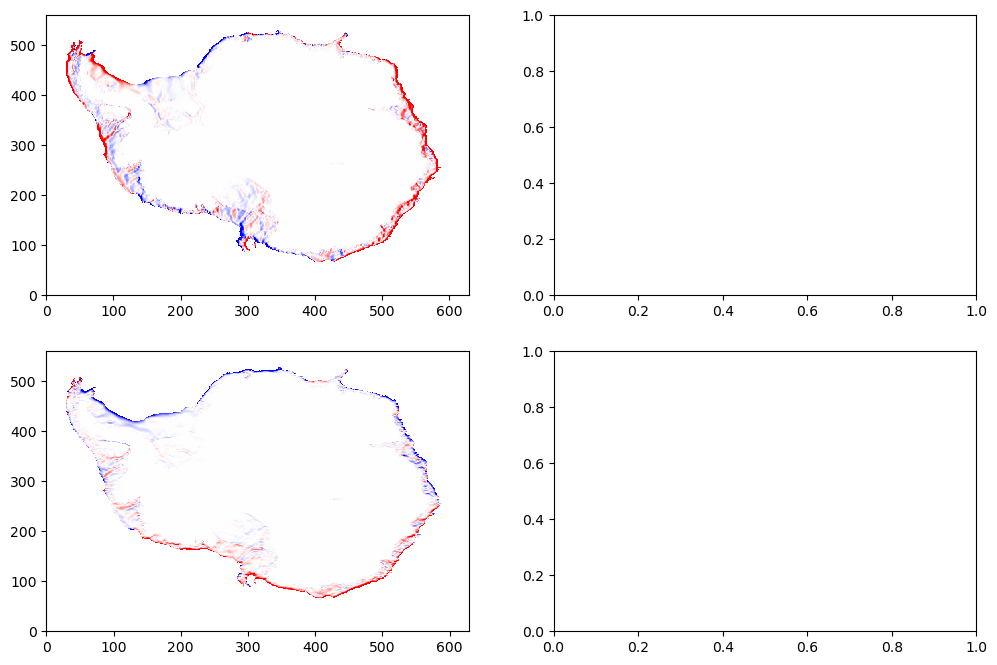

In [43]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (12, 8))

axs[0,0].pcolormesh(HTv.sum('s_rho').mean('ocean_time').values*mask_shelfc[:-1,:]*1e-12,  vmin=-3, vmax=3, cmap='bwr')

# axs[0,1].pcolormesh(HTvm.sum('s_rho').mean('ocean_time')*1e-12, vmin=-3, vmax=3, cmap='bwr')

axs[1,0].pcolormesh(HTu.sum('s_rho').mean('ocean_time').values*mask_shelfc[:,:-1]*1e-12, vmin=-5, vmax=5, cmap='bwr')

# axs[1,1].pcolormesh(HTum.sum('s_rho').mean('ocean_time')*1e-12, vmin=-2, vmax=2, cmap='bwr')
# plt.colorbar()



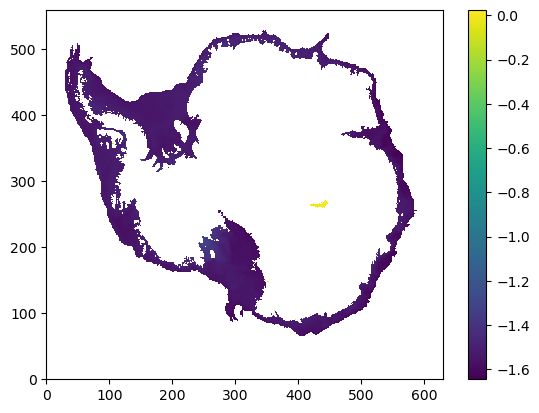

In [44]:
plt.pcolormesh(ssh.mean('ocean_time').values*mask_shelfc)#, vmin=650, vmax=850)
plt.colorbar()
# plt.xlim(250,400

In [45]:
ssh_annual = ssh.mean('ocean_time').values*mask_shelfc
print(ssh_annual.shape)
ssh_ts = ssh.values*mask_shelfc
ssh_sum = np.nansum(np.nansum(ssh_annual, axis=1), axis=0)
ssh_avg = np.nanmean(np.nanmean(ssh_annual, axis=1), axis=0)
ssh_avg_ts = np.nanmean(np.nanmean(ssh_ts, axis=2), axis=1)

(560, 630)


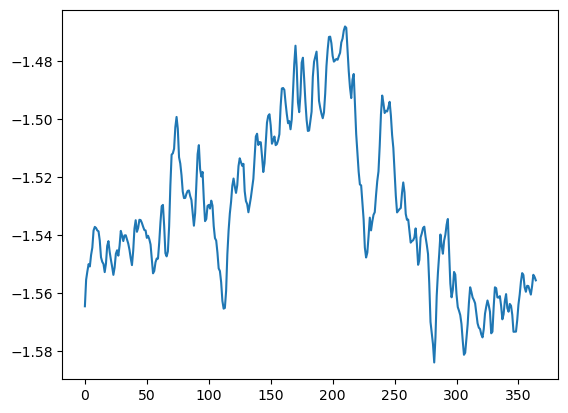

In [46]:
plt.plot(ssh_avg_ts)#, vmin=650, vmax=850)


ssh averaged over the shelf (using same mask from the contour) looks ok (i.e. not increasing in a way that ~20Sv are going southward); 10cm of seasonal variation

In [47]:
# convert temp to DataArray to extract values along contour:
months=np.arange(0,365)*(1/30.41667)

# Convert heat transport to data arrays:
coordinates3Du = dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_u=(['eta_u'], np.arange(0,560)), xi_u=(['xi_u'], np.arange(0,629)))
coordinates3Dv = dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_v=(['eta_v'], np.arange(0,559)), xi_v=(['xi_v'], np.arange(0,630)))

# - handling x/y transports (Hvom, Huon [m3.s-1]) to calculate heat transport
Huon_xr = xr.DataArray(Huon, coords = coordinates3Du, dims = ['ocean_time','s_rho','eta_u', 'xi_u'])
Hvom_xr = xr.DataArray(Hvom, coords = coordinates3Dv, dims = ['ocean_time','s_rho','eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
Huon_xr = Huon_xr.rename({'eta_u': 'eta','xi_u': 'xi'})
Hvom_xr = Hvom_xr.rename({'eta_v': 'eta','xi_v': 'xi'})


In [48]:
print(HTu.shape)

(365, 31, 560, 629)


In [49]:
%%time
# new version mimicing access-om2-01 script CSHT_IAF_non_paralelized.ipynb:

# keep daily data:

def extract_transp_across_contour(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]
    tlen = len(HTu[:,0,0,0])
    zlen = len(HTu[0,:,0,0])
    print(zlen)
    heat_transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

    for tt in range(0,tlen):
    # tt=0
        for zz in range(0,zlen): # loop through z-levels
            # 1st: stack mask_x/y_transport
            x_along_1d = mask_x_transport.stack(contour_index = ['eta', 'xi'])
            x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
            y_along_1d = mask_y_transport.stack(contour_index = ['eta', 'xi'])
            y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)
    	
            # combine all points on contour, to obtain a matrix with transport directions:
            transp_dir = xr.concat((x_along_1d, y_along_1d), dim = 'contour_index')
            transp_dir = transp_dir.sortby(contour_ordering)
            transp_dir.coords['contour_index'] = contour_index_array
            transp_dir = transp_dir.load()
                
            var_x_tmp = var_x[tt,zz,:,:]
            var_y_tmp = var_y[tt,zz,:,:]
    
            # stack transports into 1d and drop any points not on contour:
            x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
            x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
            y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
            y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)
    
            # combine all points on contour:
            heat_transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
            heat_transp_across_contour_tmp = heat_transp_across_contour_tmp.sortby(contour_ordering)
            heat_transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            heat_transp_across_contour_tmp = (heat_transp_across_contour_tmp*transp_dir).load()
            
            print(zz, heat_transp_across_contour.shape)
            heat_transp_across_contour[tt,zz,:] = heat_transp_across_contour_tmp
            del heat_transp_across_contour_tmp
        
    return heat_transp_across_contour

# extract variables:
# heat transport
# heat_trans_across_contour = extract_transp_across_contour(HTu, HTv)


CPU times: user 3 µs, sys: 16 µs, total: 19 µs
Wall time: 39.8 µs


In [50]:
%%time
# new version mimicing access-om2-01 script CSHT_IAF_non_paralelized.ipynb:

# Annual average on the run:

def extract_transp_across_contour_tavg(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]
    zlen = len(HTu[0,:,0,0])
    print(zlen)
    heat_transp_across_contour_tavg = np.empty((zlen,len(contour_ordering)))

    for zz in range(0,zlen): # loop through z-levels
        # 1st: stack mask_x/y_transport
        x_along_1d = mask_x_transport.stack(contour_index = ['eta', 'xi'])
        x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
        y_along_1d = mask_y_transport.stack(contour_index = ['eta', 'xi'])
        y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)
    
        # combine all points on contour, to obtain a matrix with transport directions:
        transp_dir = xr.concat((x_along_1d, y_along_1d), dim = 'contour_index')
        transp_dir = transp_dir.sortby(contour_ordering)
        transp_dir.coords['contour_index'] = contour_index_array
        transp_dir = transp_dir.load()

        # print(var_x)
        var_x_tmp = var_x.mean('ocean_time').isel(s_rho=zz)
        var_y_tmp = var_y.mean('ocean_time').isel(s_rho=zz)

        # 2nd: stack transports into 1d and drop any points not on contour:
        x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
        x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
        y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
        y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

        # combine all points on contour:
        heat_transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
        heat_transp_across_contour_tmp = heat_transp_across_contour_tmp.sortby(contour_ordering)
        heat_transp_across_contour_tmp.coords['contour_index'] = contour_index_array
        heat_transp_across_contour_tmp = (heat_transp_across_contour_tmp*transp_dir).load()
        
        print(zz, heat_transp_across_contour_tmp.shape)
        heat_transp_across_contour_tavg[zz,:] = heat_transp_across_contour_tmp
        del heat_transp_across_contour_tmp
        
    return heat_transp_across_contour_tavg

# extract variables:
# heat transport
heat_trans_across_contour_tavg = extract_transp_across_contour_tavg(HTu, HTv)


31
0 (2690,)
1 (2690,)
2 (2690,)
3 (2690,)
4 (2690,)
5 (2690,)
6 (2690,)
7 (2690,)
8 (2690,)
9 (2690,)
13 (2690,)
14 (2690,)
15 (2690,)
16 (2690,)
17 (2690,)
18 (2690,)
19 (2690,)
20 (2690,)
21 (2690,)
22 (2690,)
23 (2690,)
24 (2690,)
25 (2690,)
26 (2690,)
27 (2690,)
28 (2690,)
29 (2690,)
30 (2690,)
CPU times: user 41min 16s, sys: 32min 39s, total: 1h 13min 55s
Wall time: 51min 10s


In [54]:
heat_trans_across_contour_tavg.shape

(31, 2690)

(-500000000000000.0, 500000000000000.0)

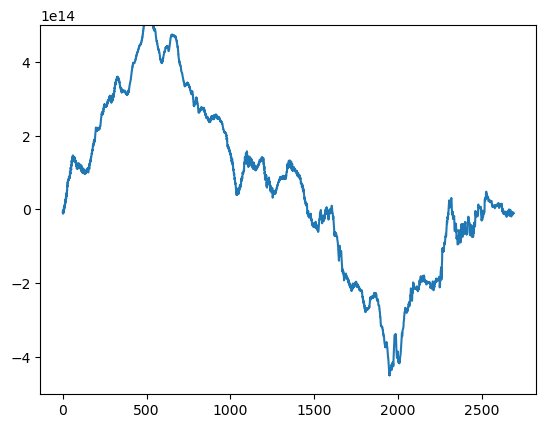

In [59]:
# plt.plot(np.cumsum(np.sum(np.nanmean(heat_trans_across_contour, axis=0), axis=0)))
plt.plot(np.cumsum(np.sum(heat_trans_across_contour_tavg, axis=0)))
plt.ylim(-5e14,5e14)

In [ ]:
%%time
## repeat for annual mean to check with Claire's example:

# defin function to extract any 4D var along the contour line

def extract_transp_across_contour_tavg(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[0,:,0,0])
    print(zlen)
    transp_across_contour = np.empty((zlen,len(contour_ordering)))

    for zz in range(0,zlen): # loop through z-levels
 
        # var_x_tmp = var_x[zz,:,:]*mask_x_transport[:,:-1] # the bug fixed in the -40Sv Vol transport came from here;
        # var_y_tmp = var_y[zz,:,:]*mask_y_transport[:-1,:] # the mask_x/y_transport are thought based on the staggeering grid alreadry
                                                          # (double-check for converting from B-Grid to C-Grid [Fabio, Mar24])   
                                                          # so the interpol. to u/v grid (done before) weren't necessary; they actually
                                                          # messed up the fluxes in a way that the circum-Ant. integral weren't Zero.
        var_x_tmp = var_x[zz,:,:]
        var_y_tmp = var_y[zz,:,:]

        
        # stack transports into 1d and drop any points not on contour:
        x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
        x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
        y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
        y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

        # combine all points on contour:
        transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
        transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
        transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
        transp_across_contour_tmp.coords['contour_index'] = contour_index_array
        transp_across_contour_tmp = transp_across_contour_tmp.load()

        print(zz, transp_across_contour_tmp.shape)
        transp_across_contour[zz,:] = transp_across_contour_tmp
        del transp_across_contour_tmp

    return transp_across_contour

# extract variables:
# 1. vol transports
vol_trans_across_contour_tavg = extract_transp_across_contour_tavg(Huon_xr.mean('ocean_time')*mask_x_transport[:,:-1], Hvom_xr.mean('ocean_time')*mask_y_transport[:-1,:])

# 2. heat transport
# heat_trans_across_contour_tavg = extract_transp_across_contour_tavg(HTum.mean('ocean_time'), HTvm.mean('ocean_time'))


In [45]:
def extract_tracer_along_contour_tavg(var):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[0,:,0,0])
    print(zlen)
    tracer_along_contour = np.empty((zlen,len(contour_ordering)))

    for zz in range(0,zlen): # loop through z-levels
 
        var_tmp = var[zz,:,:]
        
        # stack transports into 1d and drop any points not on contour:
        x_var_1d_tmp = var_tmp.stack(contour_index = ['eta', 'xi'])
        x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
        y_var_1d_tmp = var_tmp.stack(contour_index = ['eta', 'xi'])
        y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

        # combine all points on contour:
        tracer_along_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
        tracer_along_contour_tmp = tracer_along_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
        tracer_along_contour_tmp = tracer_along_contour_tmp.sortby(contour_ordering)
        tracer_along_contour_tmp.coords['contour_index'] = contour_index_array
        tracer_along_contour_tmp = tracer_along_contour_tmp.load()

        print(zz, tracer_along_contour_tmp.shape)
        tracer_along_contour[zz,:] = tracer_along_contour_tmp
        del tracer_along_contour_tmp

    return tracer_along_contour

# convert temp to DataArray to extract values along contour:
months=np.arange(0,365)*(1/30.41667)
coordinatesT=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))
temp_xr = xr.DataArray(temp, coords = coordinatesT, dims = ['ocean_time','s_rho','eta_rho', 'xi_rho'])
# rename dimensions as simply eta/xi
temp_xr = temp_xr.rename({'eta_rho': 'eta','xi_rho': 'xi'})

# extract variables:
temp_along_contour_tavg = extract_tracer_along_contour_tavg(temp_xr.mean('ocean_time'))



31
0 (2690,)
1 (2690,)
2 (2690,)
3 (2690,)
4 (2690,)
5 (2690,)
6 (2690,)
7 (2690,)
8 (2690,)
9 (2690,)
10 (2690,)
11 (2690,)
12 (2690,)
13 (2690,)
14 (2690,)
15 (2690,)
16 (2690,)
17 (2690,)
18 (2690,)
19 (2690,)
20 (2690,)
21 (2690,)
22 (2690,)
23 (2690,)
24 (2690,)
25 (2690,)
26 (2690,)
27 (2690,)
28 (2690,)
29 (2690,)
30 (2690,)


In [46]:
# define dist and z coordinates for pcolormesh plot:
expt='WAOM10'
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_1500m_v3')
dist_along_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_1500m_daily_v3')
z_rho_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_1500m_v3')
distance_indices_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

[dist_along_axis_10km, Zaxis_10km] = np.meshgrid(dist_along_10km, np.arange(0,31))


In [47]:
# np.cumsum(np.sum(vol_trans_across_contour_tavg, axis=0), axis=0)[0]*1e-6   # m3/s * 86400*365

# np.nanmax(np.nanmean(temp_along_contour_tavg,axis=0),axis=0)


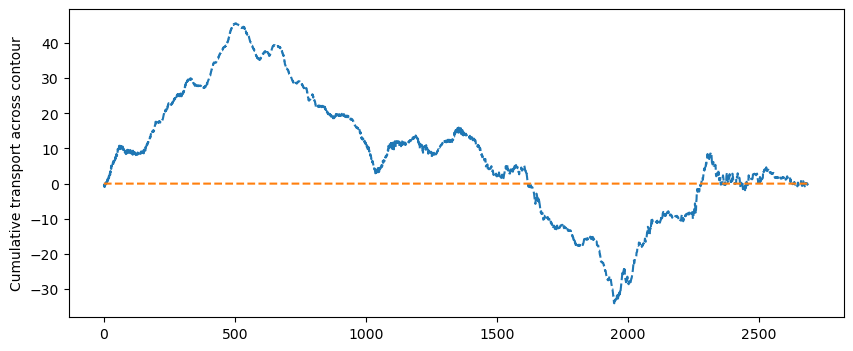

In [59]:
# plot Volume transport:

fig, ax = plt.subplots(figsize = (10, 4))

# plt.plot(np.cumsum(np.sum(np.nanmean(vol_trans_across_contour, axis=0), axis=0), axis=0))
plt.plot(np.cumsum(np.sum(vol_trans_across_contour_tavg, axis=0), axis=0)*1e-6,'--')
# plt.plot(np.sum(vol_trans_across_contour_tavg, axis=0),'--')
plt.plot(np.zeros(len(vol_trans_across_contour_tavg[0,:])),'--')
ax.set_ylabel('Cumulative transport across contour');


In [60]:
# calculate Tf heat transport
Tf_heat_transport = vol_trans_across_contour_tavg*Tf*rho0*Cp

# calculate mean eddy
mean_ht = vol_trans_across_contour_tavg*(temp_along_contour_tavg-Tf)*rho0*Cp

print(mean_ht.shape, heat_trans_across_contour_tavg.shape)


(31, 2690) (31, 2690)


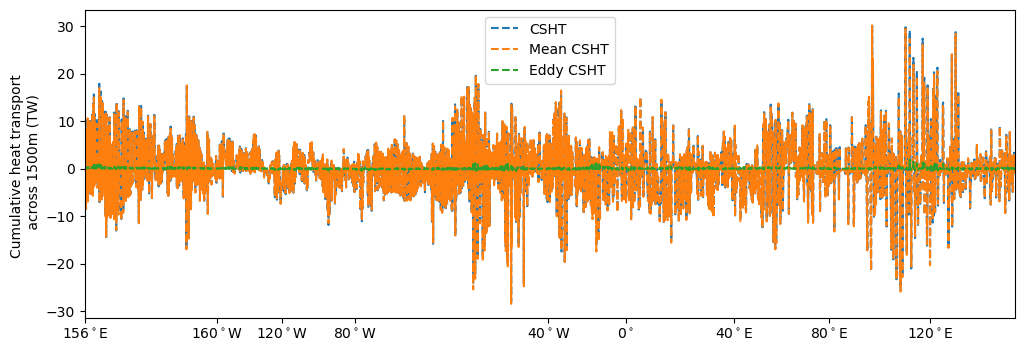

In [62]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'

fig, ax = plt.subplots(figsize = (12, 4))
plt.plot(dist_along_10km,np.divide(np.sum(heat_trans_across_contour_tavg, axis=0),1)*1e-12,'--', label='CSHT') # divide by 1000
plt.plot(dist_along_10km,np.divide(np.sum(mean_ht, axis=0),1)*1e-12,'--', label='Mean CSHT')
# plt.plot(dist_along_10km,-np.divide(np.sum(Tf_heat_transport, axis=0),1)*1e-12,'--',label='Tf HT x(-1)')
plt.plot(dist_along_10km,np.divide(np.sum(heat_trans_across_contour_tavg-mean_ht, axis=0),1)*1e-12,'--', label='Eddy CSHT')

ax.set_ylabel('Cumulative heat transport \n across 1500m (TW)');
plt.legend()
# plt.ylim(-500,2500)

ax.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax.set_xlim(0, dist_along_10km[-1])
# ax.set_aspect('auto')
ax.tick_params(labelsize=10)

plt.savefig(fig_path + 'WAOM10_Cross-1500m_vint_NonCumsum_MeanEddy_v4.png', bbox_inches='tight', dpi=300)
plt.show()

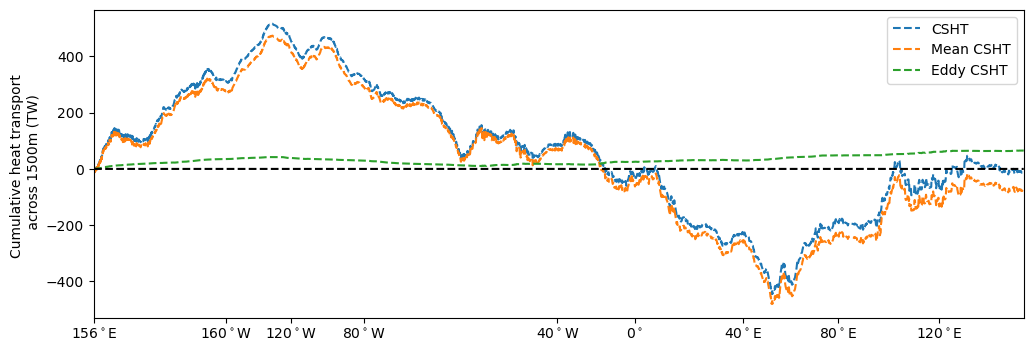

In [67]:

fig, ax = plt.subplots(figsize = (12, 4))

plt.plot(dist_along_10km,np.cumsum(np.divide(np.sum(heat_trans_across_contour_tavg, axis=0),1), axis=0)*1e-12,'--', label='CSHT')
plt.plot(dist_along_10km,np.cumsum(np.divide(np.sum(mean_ht, axis=0),1), axis=0)*1e-12,'--', label='Mean CSHT')
# plt.plot(dist_along_10km,-np.cumsum(np.divide(np.sum(Tf_heat_transport, axis=0),1), axis=0)*1e-12,'--',label='Tf HT x(-1)')
plt.plot(dist_along_10km,np.cumsum(np.divide(np.sum(heat_trans_across_contour_tavg-mean_ht, axis=0),1), axis=0)*1e-12,'--', label='Eddy CSHT')
plt.plot(dist_along_10km,np.sum(mean_ht, axis=0)*0,'--k')
ax.set_ylabel('Cumulative heat transport \n across 1500m (TW)');
plt.legend()
# plt.ylim(-500,2500)

ax.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax.set_xlim(0, dist_along_10km[-1])
# ax.set_aspect('auto')
ax.tick_params(labelsize=10)

plt.savefig(fig_path + 'WAOM10_Cross-1500m_vint_MeanEddy_Tf_v4.png', bbox_inches='tight', dpi=300)
plt.show()

In [1]:

# fig, ax = plt.subplots(figsize = (9, 3))
fig, axs = plt.subplots(nrows=3, figsize = (12, 9.2))

axs[0].pcolormesh(dist_along_axis_10km, np.nanmean(z_rho_10km, axis=0),heat_trans_across_contour_tavg*1e-12, vmin=-1.5, vmax=1.5, cmap='bwr')
axs[0].set_title('Total cross-1500m heat transport')

axs[1].pcolormesh(dist_along_axis_10km, np.nanmean(z_rho_10km, axis=0),mean_ht*1e-12, vmin=-1.5, vmax=1.5, cmap='bwr')
axs[1].set_title('Mean cross-1500m heat transport')

aa=axs[2].pcolormesh(dist_along_axis_10km, np.nanmean(z_rho_10km, axis=0),(heat_trans_across_contour_tavg-mean_ht)*1e-12, vmin=-1.5, vmax=1.5, cmap='bwr')
axs[2].set_title('Eddy (residual Total - Mean) cross-1500m heat transport')

cbar_ax2 = fig.add_axes([0.91, 0.11,  0.01, 0.77])
fig.colorbar(aa, cax=cbar_ax2, orientation='vertical')
cbar_ax2.set_ylabel('TW')#, labelpad=-35)

for aa in range(0,3):

    axs[aa].set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
    axs[aa].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                              '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
    axs[aa].set_xlim(0, dist_along_10km[-1])
    axs[aa].set_yscale('symlog',base = 2, linthresh=700)
    axs[aa].set_ylabel('Depth (m, symlog$_2$)')
    axs[aa].set_yticklabels(['-2000','-1000','-500'])
    axs[aa].set_aspect('auto')
    axs[aa].tick_params(labelsize=12)

plt.savefig(fig_path + 'WAOM10_Cross-1500m_perDepth_MeanEddy_v4.png', bbox_inches='tight', dpi=300)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
fig, ax = plt.subplots(figsize = (9, 3))

plt.pcolormesh(Tf_heat_transport*1e-12, vmin=-1.5, vmax=1.5, cmap='bwr')
plt.colorbar()

In [52]:
# define a function to extract any 4D var along the contour line

def extract_transp_across_contour(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

    zlen = len(temp[0,:,0,0])
    tlen = len(temp[:,0,0,0])
    print(tlen,zlen)
    transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))
    ## transp_across_contour = np.empty((1,zlen,len(contour_ordering)))

    for tt in range(0,tlen): # loop through time
        for zz in range(0,zlen): # loop through z-levels

            # print('Debugging high memory usage: ')
            # print(tt, zz)

            var_x_tmp = var_x[tt,zz,:,:]*mask_x_transport[:,:-1] # the bug fixed in the -40Sv Vol transport came from here;
            var_y_tmp = var_y[tt,zz,:,:]*mask_y_transport[:-1,:] # the mask_x/y_transport are thought based on the staggeering grid alreadry
                                                          # (double-check for converting from B-Grid to C-Grid [Fabio, Mar24])   
                                                          # so the interpol. to u/v grid (done before) weren't necessary; they actually
                                                          # messed up the fluxes in a way that the circum-Ant. integral weren't Zero.

            # print('var_x_tmp/var_y_tmp shapes after mask multip.:')
            # print(var_x_tmp.shape, var_y_tmp.shape)

            # stack transports into 1d and drop any points not on contour:
            x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
            x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
            y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
            y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

            # print('x_var_1d_tmp/y_var_1d_tmp shapes after stack:')
            # print(x_var_1d_tmp.shape, y_var_1d_tmp.shape)

            # combine all points on contour:
            transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
            transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
            transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering)
            transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            transp_across_contour_tmp = transp_across_contour_tmp.load()

            print(tt, zz, transp_across_contour_tmp.shape)
            transp_across_contour[tt,zz,:] = transp_across_contour_tmp
            del transp_across_contour_tmp

    return transp_across_contour

In [ ]:
# extract variables:
# 1. vol transp
# vol_trans_across_contour = extract_transp_across_contour(Huon_xr, Hvom_xr)

# heat_trans_across_contour = extract_transp_across_contour(HTum, HTvm)


365 31
0 0 (2690,)
0 1 (2690,)
0 2 (2690,)
0 3 (2690,)
0 4 (2690,)
0 5 (2690,)
0 6 (2690,)
0 7 (2690,)
0 8 (2690,)
0 9 (2690,)
0 10 (2690,)
0 11 (2690,)
0 12 (2690,)
0 13 (2690,)
0 14 (2690,)
0 15 (2690,)
0 16 (2690,)
0 17 (2690,)
0 18 (2690,)
0 19 (2690,)
0 20 (2690,)
0 21 (2690,)
0 22 (2690,)
0 23 (2690,)
0 24 (2690,)
0 25 (2690,)
0 26 (2690,)
0 27 (2690,)
0 28 (2690,)
0 29 (2690,)
0 30 (2690,)
1 0 (2690,)
1 1 (2690,)
1 2 (2690,)
1 3 (2690,)
1 4 (2690,)
1 5 (2690,)
1 6 (2690,)
1 7 (2690,)
1 8 (2690,)
1 9 (2690,)
1 10 (2690,)
1 11 (2690,)
1 12 (2690,)
1 13 (2690,)
1 14 (2690,)
1 15 (2690,)
1 16 (2690,)
1 17 (2690,)
1 18 (2690,)
1 19 (2690,)
1 20 (2690,)
1 21 (2690,)
1 22 (2690,)
1 23 (2690,)
1 24 (2690,)
1 25 (2690,)
1 26 (2690,)
1 27 (2690,)
1 28 (2690,)
1 29 (2690,)
1 30 (2690,)
2 0 (2690,)
2 1 (2690,)
2 2 (2690,)
2 3 (2690,)
2 4 (2690,)
2 5 (2690,)
2 6 (2690,)
2 7 (2690,)
2 8 (2690,)
2 9 (2690,)
2 10 (2690,)
2 11 (2690,)
2 12 (2690,)
2 13 (2690,)
2 14 (2690,)
2 15 (2690,)
2 16 (269

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))

plt.plot(np.cumsum(np.sum(np.nanmean(vol_trans_across_contour, axis=0), axis=0), axis=0))
plt.plot(np.cumsum(np.sum(vol_trans_across_contour_tavg, axis=0), axis=0),'--')
ax.set_ylabel('Cumulative transport across contour');

(350.0, 500.0)

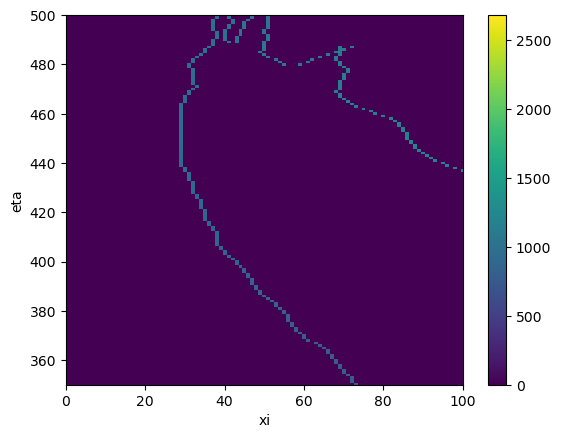

In [61]:
mask_x_transport_numbered.plot()
# mask_x_transport.plot()
plt.xlim(0,100)
plt.ylim(350,500)

(350.0, 500.0)

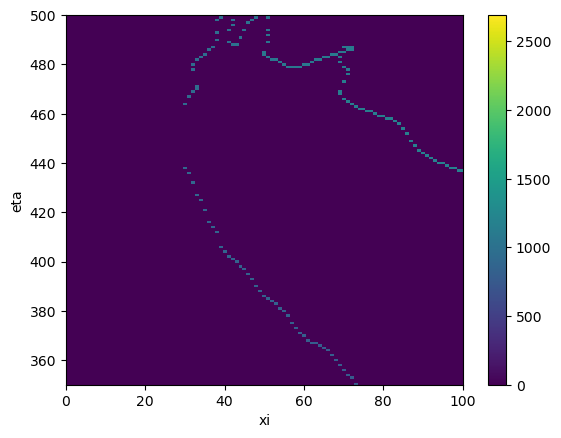

In [62]:
mask_y_transport_numbered.plot()
# mask_y_transport.plot()
plt.xlim(0,100)
plt.ylim(350,500)

In [80]:
### Code to extract distance in between contour coordinates, using length of diagonal if there is a bend.
#Loop through the contour, determining if diagonal is required or not, and save the distance along each segment. Then, cumulatively sum the distances along each segment to get the distance from the first point.
#If there is a bend in the contour, then half the diagonal distance is added to each side to avoid artifically inflating the along-contour distance metric, according to this diagram:

num_points = len(lat_along_contour)

# if there is a bend in the contour, add the distance using the half-length of the diagonal
# instead of the sum of 2 edges, to be more representative.
distance_along_contour = np.zeros((num_points))

x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])

skip = False
# note dxu and dyt do not vary in x, so we can just take the first value (as long as there is no land there,
# which for this latitude range there is not. If using a different latitude range, choose an x value that is
# not a nan/land for the entire latitude range
dxu = np.divide(1,pm)
dyt = np.divide(1,pn)

for count in range(1, num_points):
    if skip == True:
        skip = False
        continue
    if count in y_indices:
        if count + 1 in y_indices:
            # note dxu and dyt do not vary in x:
            jj = np.where(mask_y_transport_numbered==count)#[0]
            # print(count, jj)
            distance_along_contour[count-1] = (dxu[jj])#[0]
        else:
            jj0 = np.where(mask_y_transport_numbered==count)#[0]
            jj1 = np.where(mask_x_transport_numbered==count+1)#[0]
            half_diagonal_distance = 0.5 * np.sqrt((dxu[jj0])**2 + (dyt[jj1])**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

    # count in x_indices:
    else:
        if count + 1 in x_indices:
            jj = np.where(mask_x_transport_numbered==count)#[0]
            distance_along_contour[count-1] = (dyt[jj])#[0]
        else:
            jj0 = np.where(mask_x_transport_numbered==count)#[0]
            jj1 = np.where(mask_y_transport_numbered==count+1)#[0]
            half_diagonal_distance = 0.5 * np.sqrt((dyt[jj0])**2 + (dxu[jj1])**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

# fix last value:
if distance_along_contour[-1] == 0:
    count = count + 1
    if count in y_indices:
        jj = np.where(mask_y_transport_numbered==count)#[0]
        distance_along_contour[-1] = (dxu[jj])#[0]
    else:
        jj = np.where(mask_x_transport_numbered==count)#[0]
        distance_along_contour[-1] = (dyt[jj])#[0]

# units are 10^3 km:
distance_along_contour = np.cumsum(distance_along_contour) / 1e3 / 1e3


# --- Select the indices for axis labels of specific longitudes,
# so we can plot transport vs distance but have longitude labels instead of length

distance_indices = np.zeros(9)

for i in np.arange(100, len(lon_along_contour.one)):
    # print(i)
    if (distance_indices[1]==0):
        if (lon_along_contour.one[i]>-160 and lon_along_contour.one[i]<-159):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.one[i]>-120 and lon_along_contour.one[i]<-119):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.one[i]>-80  and lon_along_contour.one[i]<-79):
             distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if (lon_along_contour.one[i]>-40 and lon_along_contour.one[i]<-39):
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.one[i]>0 and lon_along_contour.one[i]<1):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.one[i]>40 and lon_along_contour.one[i]<41):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
    if (distance_indices[7]==0):
        if (lon_along_contour.one[i]>80 and lon_along_contour.one[i]<81):
            distance_indices[7] = lon_along_contour.contour_index.values[i]
    if (distance_indices[8]==0):
        if (lon_along_contour.one[i]>120 and lon_along_contour.one[i]<121):
            distance_indices[8] = lon_along_contour.contour_index.values[i]

#distance_indices[13] = len(lon_along_contour.contour_index.values)-1

print('Debugging lenght error in the to_netcdf function:')
print('contour_index_array len, lon_along_contour/lat_along_contour/distance_along_contour shapes:')
print(len(contour_index_array))
print(lon_along_contour.shape)
print(lat_along_contour.shape)
print(distance_along_contour.shape)

Debugging lenght error in the to_netcdf function:
contour_index_array len, lon_along_contour/lat_along_contour/distance_along_contour shapes:
2690
(2690,)
(2690,)
(2690,)


In [78]:
lon_along_contour

array([156.09445372, 156.09445372, 156.29986293, ..., 155.6855897 ,
       155.88969527, 156.09445372])